##### Copyright 2018 Google LLC. & OpenAI

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Inversion Caricatures

This notebook experiments with combining ideas from the [caricature notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/misc/feature_inversion_caricatures.ipynb) with attribution betwen layers.

## Install, Import, Load Model

In [0]:
!pip install --upgrade --quiet git+https://github.com/tensorflow/lucid.
#tensorflow_version only works on colab
%tensorflow_version 1.x

In [0]:
# Import libraries
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('1')
import scipy.ndimage as nd

from google.colab import files

import lucid.modelzoo.vision_models as models
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.io import show, load
from lucid.misc.io.reading import read

from lucid.misc.gradient_override import gradient_override_map

In [0]:
# Import the InceptionV1 (GoogLeNet) model from the Lucid modelzoo

model = models.InceptionV1()
model.load_graphdef()

## Setup

In [0]:
def imgToModelSize(arr):
  W = model.image_shape[0]
  w, h, _ = arr.shape
  s = float(W) / min(w,h)
  arr = nd.zoom(arr, [s, s, 1], mode="nearest")
  w, h, _ = arr.shape
  dw, dh = (w-W)//2, (h-W)//3
  return arr[dw:dw+W, dh:dh+W]

In [0]:
def make_MaxSmoothPoolGrad():
  def MaxPoolGrad(op, grad):
    inp = op.inputs[0]
    
    op_args = [op.get_attr("ksize"), op.get_attr("strides"), op.get_attr("padding")]
    smooth_out = tf.nn.avg_pool(inp**2, *op_args)/ (1e-2+tf.nn.avg_pool(tf.abs(inp), *op_args))
    inp_smooth_grad = tf.gradients(smooth_out, [inp], grad)[0]
      
    return inp_smooth_grad
  return MaxPoolGrad


def make_attr(t_obj, t_layer):
  with gradient_override_map({"MaxPool": make_MaxSmoothPoolGrad()}):
    t_grad = tf.gradients(t_obj, [t_layer])[0]
  return tf.stop_gradient( t_layer * t_grad )


@objectives.wrap_objective
def as_obj(obj):
  if isinstance(obj, str):
    if obj in model.labels:
      class_n = model.labels.index(obj)
      return lambda T: T("softmax2_pre_activation")[:, class_n]
    if any([layer.name == obj for layer in model.layers]):
      return lambda T: tf.reduce_sum( T(obj)**2 )
  else:
    return lambda T: obj(T)

  
@objectives.wrap_objective
def caricature_obj(layers, attr_obj=None):
  if isinstance(layers, str):
    layers = [layers]
  if attr_obj is None:
    attr_obj = layers[-1]
  
  def obj(T):
    t_obj = as_obj(attr_obj)(T)
    
    for layer in reversed(layers):
      t_layer = T(layer)
      t_attr = make_attr(t_obj, t_layer)
      t_attr = t_attr / tf.reduce_max(t_attr, axis=[1,2,3], keepdims=True)
      t_obj = t_layer * t_attr
    
    return tf.reduce_sum(t_layer[1] * t_attr[0])
  return obj


def feature_inversion(img, obj, n_steps=512):
  with tf.Graph().as_default(), tf.Session() as sess:
    img = imgToModelSize(img)

    t_input = tf.placeholder(tf.float32, img.shape)
    param_f = param.image(img.shape[0], decorrelate=True, fft=True, alpha=False)
    param_f = tf.stack([t_input, param_f[0]])

    T = render.make_vis_T(model, obj, param_f)
    loss, vis_op, t_image = T("loss"), T("vis_op"), T("input")

    tf.global_variables_initializer().run()
    for i in range(n_steps): _ = sess.run([vis_op], {t_input: img})

    result = t_image.eval(feed_dict={t_input: img})
    show(result[1])
    

# Experiments

In [0]:
img_dogcat = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")


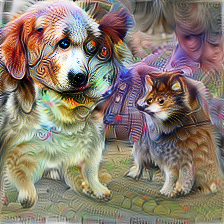

In [9]:
# Regular caricature at mixed4d

obj = caricature_obj("mixed4d")
feature_inversion(img_dogcat, obj)


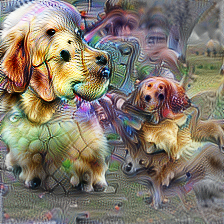


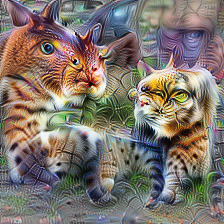


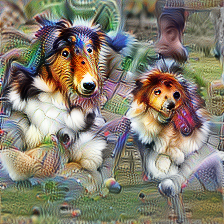

In [10]:
# Caricatures of class attributions to mixed4d

for class_name in ["golden retriever", "tiger cat", "collie"]:
  obj = caricature_obj("mixed4d", class_name)
  feature_inversion(img_dogcat, obj)


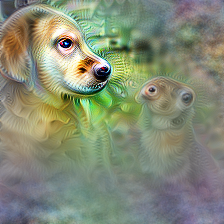


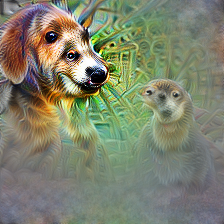


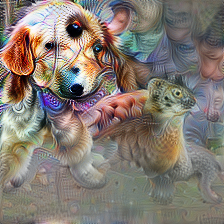

In [13]:
# Iterated attribution
# Warning: it isn't clear this is very (or at all!) principled

# to mixed3a
obj = caricature_obj(["mixed3a", "mixed3b", "mixed4a", "mixed4b", "mixed4c", "mixed4d", "mixed4e", "mixed5a", "mixed5b"])
feature_inversion(img_dogcat, obj)

# to mixed4a
obj = caricature_obj(["mixed4a", "mixed4b", "mixed4c", "mixed4d", "mixed4e", "mixed5a", "mixed5b"])
feature_inversion(img_dogcat, obj)

# to mixed4d
obj = caricature_obj(["mixed4d", "mixed4e", "mixed5a", "mixed5b"])
feature_inversion(img_dogcat, obj)


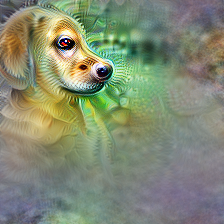


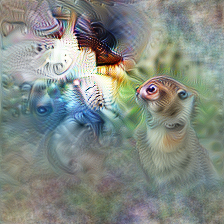


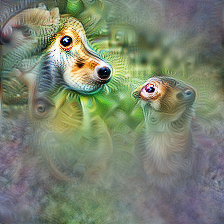

In [14]:
# Caricatures of class attributions to mixed4d

for class_name in ["golden retriever", "tiger cat", "collie"]:
  obj = caricature_obj(["mixed3a", "mixed3b", "mixed4a", "mixed4b", "mixed4c", "mixed4d", "mixed4e", "mixed5a", "mixed5b"], class_name)
  feature_inversion(img_dogcat, obj)